In [1]:
#############################################################
## ASSIGNMENT 2 CODE SKELETON
## RELEASED: 1/29/2019
## DUE: 2/5/2019
## DESCRIPTION: In this assignment, you will explore the
## text classification problem of identifying complex words.
## We have provided the following skeleton for your code,
## with several helper functions, and all the required
## functions you need to write.
#############################################################

from collections import defaultdict
import gzip
import numpy as np
import re
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

training_file = '/Users/sppatankar/Desktop/CIS 530/Homework 2/data/complex_words_training.txt'
development_file = '/Users/sppatankar/Desktop/CIS 530/Homework 2/data/complex_words_development.txt'

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sppatankar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sppatankar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#### 1. Evaluation Metrics ####

## Input: y_pred, a list of length n with the predicted labels,
## y_true, a list of length n with the true labels

## Calculates the precision of the predicted labels
def get_precision(y_pred, y_true):
    # true positive: system says positive when truly positive
    true_positives = len([pred for idx, pred in enumerate(y_pred) if pred == 1 if y_true[idx] == 1])
    # false positive = system says positive when truly negative
    false_positives = len([pred for idx, pred in enumerate(y_pred) if pred == 1 if y_true[idx] == 0])
    precision = true_positives / (true_positives + false_positives)
    return precision
    
## Calculates the recall of the predicted labels
def get_recall(y_pred, y_true):
    # true positive: system says positive when truly positive
    true_positives = len([pred for idx, pred in enumerate(y_pred) if pred == 1 if y_true[idx] == 1])
    # false negative = system says negative when truly positive
    false_negatives = len([pred for idx, pred in enumerate(y_pred) if pred == 0 if y_true[idx] == 1])
    recall = true_positives / (true_positives + false_negatives)
    return recall

## Calculates the f-score of the predicted labels
def get_fscore(y_pred, y_true):
    precision = get_precision(y_pred, y_true)
    recall = get_recall(y_pred, y_true)
    fscore = (2 * precision * recall) / (precision + recall)
    return fscore

def test_predictions(y_pred, y_true):
    precision = get_precision(y_pred, y_true)
    recall = get_recall(y_pred, y_true)
    fscore = get_fscore(y_pred, y_true)
    print('Precision = %f' % precision)
    print('Recall = %f' % recall)
    print('F1 Score = %f' % fscore)
    return 

In [3]:
#### 2. Complex Word Identification ####

## Loads in the words and labels of one of the datasets
def load_file(data_file):
    words = []
    labels = []   
    with open(data_file, 'rt', encoding = "utf8") as f:
        i = 0
        for line in f:
            if i > 0: # skips over column headers
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    return words, labels

In [4]:
### 2.1: A very simple baseline

## Makes feature matrix for all complex
def all_complex_feature(words):
    return [1 for word in words]

## Labels every word complex
def all_complex(data_file):
    words, y_true = load_file(data_file)
    y_pred = all_complex_feature(words)
    precision = get_precision(y_pred, y_true)
    recall = get_recall(y_pred, y_true)
    fscore = get_fscore(y_pred, y_true)
    performance = [precision, recall, fscore]
    test_predictions(y_pred, y_true)
    return performance

In [5]:
print('\nTraining Data')
all_complex(training_file)
print('\nDevelopment Data')
all_complex(development_file)


Training Data
Precision = 0.432750
Recall = 1.000000
F1 Score = 0.604083

Development Data
Precision = 0.418000
Recall = 1.000000
F1 Score = 0.589563


[0.418, 1.0, 0.5895627644569816]

In [6]:
### 2.2: Word length thresholding

## Makes feature matrix for word_length_threshold
def length_threshold_feature(words, threshold):
    feature = []
    for word in words:
        if len(word) >= threshold:
            feature.append(1)
        else:
            feature.append(0)
    return feature

In [7]:
data_file = '/Users/sppatankar/Desktop/CIS 530/Homework 2/data/complex_words_training.txt'
words_train_file, labels_train_file = load_file(data_file)
precisions_length = []
recalls_length = []
fscores_length = []
thresholds_length = range(10)
for threshold in thresholds_length:
    y_pred_train = length_threshold_feature(words_train_file, threshold)
    precisions_length.append(get_precision(y_pred_train, labels_train_file))
    recalls_length.append(get_recall(y_pred_train, labels_train_file))
    fscores_length.append(get_fscore(y_pred_train, labels_train_file))  

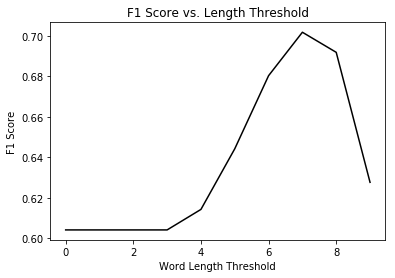

In [8]:
plt.plot(thresholds_length, fscores_length, color = 'black')
plt.title('F1 Score vs. Length Threshold')
plt.xlabel('Word Length Threshold')
plt.ylabel('F1 Score')
plt.savefig('f1_length.pdf')

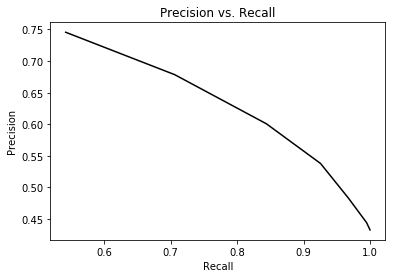

In [9]:
plt.plot(recalls_length, precisions_length, color = 'black')
plt.title('Precision vs. Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('p_r_length.pdf')

In [10]:
## Finds the best length threshold by f-score, and uses this threshold to
## classify the training and development set
def word_length_threshold(training_file, development_file):
    threshold = 7
    # training set data
    words_train_file, labels_train_file = load_file(training_file)
    y_pred_train = length_threshold_feature(words_train_file, threshold)
    tprecision = get_precision(y_pred_train, labels_train_file)
    trecall = get_recall(y_pred_train, labels_train_file)
    tfscore = get_fscore(y_pred_train, labels_train_file)
    training_performance = [tprecision, trecall, tfscore]
    print('\nTraining Data')
    test_predictions(y_pred_train, labels_train_file)

    # development set data
    words_dev_file, labels_dev_file = load_file(development_file)
    y_pred_dev = length_threshold_feature(words_dev_file, threshold)
    dprecision = get_precision(y_pred_dev, labels_train_file)
    drecall = get_recall(y_pred_dev, labels_train_file)
    dfscore = get_fscore(y_pred_dev, labels_train_file)
    development_performance = [dprecision, drecall, dfscore]
    print('\nDevelopment Data')
    test_predictions(y_pred_dev, labels_dev_file)
    
    return training_performance, development_performance

In [11]:
word_length_threshold(training_file, development_file)


Training Data
Precision = 0.600740
Recall = 0.844021
F1 Score = 0.701898

Development Data
Precision = 0.605351
Recall = 0.866029
F1 Score = 0.712598


([0.6007401315789473, 0.8440207972270364, 0.7018976699495555],
 [0.4280936454849498, 0.5752808988764045, 0.4908916586768936])

In [12]:
ngram_counts_file = '/Users/sppatankar/Desktop/CIS 530/Homework 2/ngram_counts.txt.gz'

In [13]:
### 2.3: Word frequency thresholding

## Loads Google NGram counts
def load_ngram_counts(ngram_counts_file):
    counts = defaultdict(int)
    with gzip.open(ngram_counts_file, 'rt') as f:
        for line in f:
            token, count = line.strip().split('\t')
            if token[0].islower:
                counts[token] = int(count)
    return counts

In [14]:
counts = load_ngram_counts(ngram_counts_file)

In [15]:
# Finds the best frequency threshold by f-score, and uses this threshold to
## classify the training and development set

## Make feature matrix for word_frequency_threshold

def frequency_threshold_feature(words, threshold, counts):
    feature = []
    for word in words:
        if counts[word] < threshold: # infrequent words are complex
            feature.append(1)
        else:
            feature.append(0)
    return feature

In [16]:
data_file = '/Users/sppatankar/Desktop/CIS 530/Homework 2/data/complex_words_training.txt'
words_train_file, labels_train_file = load_file(data_file)
precisions_frequency = []
recalls_frequency = []
fscores_frequency = []
thresholds_frequency = list(range(1000000, 70000000, 100000))
for threshold in thresholds_frequency:
    y_pred_train = frequency_threshold_feature(words_train_file, threshold, counts)
    precisions_frequency.append(get_precision(y_pred_train, labels_train_file))
    recalls_frequency.append(get_recall(y_pred_train, labels_train_file))
    fscores_frequency.append(get_fscore(y_pred_train, labels_train_file))

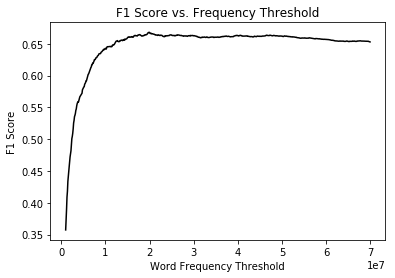

In [17]:
plt.plot(thresholds_frequency, fscores_frequency, color = 'black')
plt.title('F1 Score vs. Frequency Threshold')
plt.xlabel('Word Frequency Threshold')
plt.ylabel('F1 Score')
plt.savefig('f1_frequency.pdf')

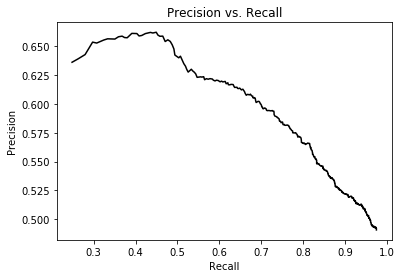

In [18]:
plt.plot(recalls_frequency, precisions_frequency, color = 'black')
plt.title('Precision vs. Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('p_r_frequency.pdf')

In [19]:
thresholds_frequency[np.argmax(fscores_frequency)]

19900000

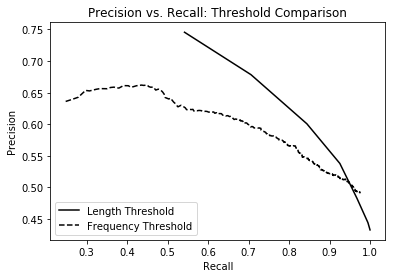

In [20]:
plt.plot(recalls_length, precisions_length, color = 'black')
plt.plot(recalls_frequency, precisions_frequency, color = 'black', linestyle='dashed')
plt.title('Precision vs. Recall: Threshold Comparison')
plt.legend(['Length Threshold', 'Frequency Threshold'], loc = 'lower left')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('threshold_comparison.pdf')

In [21]:
def word_frequency_threshold(training_file, development_file, counts):
    threshold = 19900000
    # training set data
    words_train_file, labels_train_file = load_file(training_file)
    y_pred_train = frequency_threshold_feature(words_train_file, threshold, counts)
    tprecision = get_precision(y_pred_train, labels_train_file)
    trecall = get_recall(y_pred_train, labels_train_file)
    tfscore = get_fscore(y_pred_train, labels_train_file)
    training_performance = [tprecision, trecall, tfscore]
    print('\nTraining Data')
    test_predictions(y_pred_train, labels_train_file)
    
    # development set data
    words_dev_file, labels_dev_file = load_file(development_file)
    y_pred_dev = frequency_threshold_feature(words_dev_file, threshold, counts)
    dprecision = get_precision(y_pred_dev, labels_train_file)
    drecall = get_recall(y_pred_dev, labels_train_file)
    dfscore = get_fscore(y_pred_dev, labels_train_file)
    development_performance = [dprecision, drecall, dfscore]
    print('\nDevelopment Data')
    test_predictions(y_pred_dev, labels_dev_file)
    
    return training_performance, development_performance

In [22]:
word_frequency_threshold(training_file, development_file, counts)


Training Data
Precision = 0.565705
Recall = 0.815713
F1 Score = 0.668086

Development Data
Precision = 0.556782
Recall = 0.844498
F1 Score = 0.671103


([0.5657051282051282, 0.8157134604274986, 0.6680861130825645],
 [0.4353312302839117, 0.6202247191011236, 0.5115848007414273])

In [23]:
### 2.4: Naive Bayes
        
## Trains a Naive Bayes classifier using length and frequency features
def naive_bayes(training_file, development_file, counts):
    
    words_train, labels_train = load_file(training_file)
    n_words = len(words_train)
    n_features = 2
    X_train = np.zeros((n_words, n_features))
    Y_train = np.asarray(labels_train)
    for i, row in enumerate(X_train):
        row[0] = len(words_train[i])
        row[1] = counts[words_train[i]]

    mean1, mean2 = np.mean(X_train, axis = 0)
    std1, std2 = np.std(X_train, axis = 0)

    def normalize_func(X):
        return [((X[0] - mean1) / std1),((X[1] - mean2) / std2)]

    X_train = np.apply_along_axis(normalize_func, 1, X_train)

    clf = GaussianNB()
    clf.fit(X_train, Y_train)

    Y_pred_train = clf.predict(X_train)

    tprecision = get_precision(Y_pred_train.tolist(), Y_train.tolist())
    trecall = get_recall(Y_pred_train.tolist(), Y_train.tolist())
    tfscore = get_fscore(Y_pred_train.tolist(), Y_train.tolist())
    training_performance = (tprecision, trecall, tfscore)
    print('\nTraining Data')
    test_predictions(Y_pred_train.tolist(), labels_train)

    words_dev, labels_dev = load_file(development_file)
    n_words = len(words_dev)
    X_dev = np.zeros((n_words, n_features))
    Y_dev = np.asarray(labels_dev)
    for i, row in enumerate(X_dev):
        row[0] = len(words_dev[i])
        row[1] = counts[words_dev[i]]

    X_dev = np.apply_along_axis(normalize_func, 1, X_dev)
    Y_pred_dev = clf.predict(X_dev)

    dprecision = get_precision(Y_pred_dev.tolist(), Y_dev.tolist())
    drecall = get_recall(Y_pred_dev.tolist(), Y_dev.tolist())
    dfscore = get_fscore(Y_pred_dev.tolist(), Y_dev.tolist())
    development_performance = (dprecision, drecall, dfscore)
    print('\nDevelopment Data')
    test_predictions(Y_pred_dev.tolist(), labels_dev)
    
    return development_performance

In [24]:
naive_bayes(training_file, development_file, counts)


Training Data
Precision = 0.495038
Recall = 0.979780
F1 Score = 0.657747

Development Data
Precision = 0.469293
Recall = 0.968900
F1 Score = 0.632319


(0.46929316338354576, 0.9688995215311005, 0.6323185011709602)

In [25]:
### 2.5: Logistic Regression

## Trains a Naive Bayes classifier using length and frequency features
def logistic_regression(training_file, development_file, counts):
    
    words_train, labels_train = load_file(training_file)
    n_words = len(words_train)
    n_features = 2
    X_train = np.zeros((n_words, n_features))
    Y_train = np.asarray(labels_train)
    for i, row in enumerate(X_train):
        row[0] = len(words_train[i])
        row[1] = counts[words_train[i]]

    mean1, mean2 = np.mean(X_train, axis = 0)
    std1, std2 = np.std(X_train, axis = 0)

    def normalize_func(X):
        return [((X[0] - mean1) / std1),((X[1] - mean2) / std2)]

    X_train = np.apply_along_axis(normalize_func, 1, X_train)

    clf = LogisticRegression()
    clf.fit(X_train, Y_train)

    Y_pred_train = clf.predict(X_train)

    tprecision = get_precision(Y_pred_train.tolist(), Y_train.tolist())
    trecall = get_recall(Y_pred_train.tolist(), Y_train.tolist())
    tfscore = get_fscore(Y_pred_train.tolist(), Y_train.tolist())
    training_performance = (tprecision, trecall, tfscore)
    print('\nTraining Data')
    test_predictions(Y_pred_train.tolist(), labels_train)

    words_dev, labels_dev = load_file(development_file)
    n_words = len(words_dev)
    X_dev = np.zeros((n_words, n_features))
    Y_dev = np.asarray(labels_dev)
    for i, row in enumerate(X_dev):
        row[0] = len(words_dev[i])
        row[1] = counts[words_dev[i]]

    X_dev = np.apply_along_axis(normalize_func, 1, X_dev)
    Y_pred_dev = clf.predict(X_dev)

    dprecision = get_precision(Y_pred_dev.tolist(), Y_dev.tolist())
    drecall = get_recall(Y_pred_dev.tolist(), Y_dev.tolist())
    dfscore = get_fscore(Y_pred_dev.tolist(), Y_dev.tolist())
    development_performance = (dprecision, drecall, dfscore)
    print('\nDevelopment Data')
    test_predictions(Y_pred_dev.tolist(), labels_dev)
    
    return development_performance

In [26]:
logistic_regression(training_file, development_file, counts)


Training Data
Precision = 0.725016
Recall = 0.658001
F1 Score = 0.689885

Development Data
Precision = 0.726817
Recall = 0.693780
F1 Score = 0.709914


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.7268170426065163, 0.69377990430622, 0.7099143206854344)

In [27]:
def count_syllables(word): 
    word = word.lower() 
    # exception_add are words that need extra syllables
    # exception_del are words that need less syllables
    exception_add = ['serious','crucial']
    exception_del = ['fortunately','unfortunately'] 
    co_one = ['cool','coach','coat','coal','count','coin','coarse','coup','coif','cook','coign','coiffe','coof','court']
    co_two = ['coapt','coed','coinci']
    pre_one = ['preach']
 
    syls = 0 # added syllable number
    disc = 0 # discarded syllable number
 
    #1) if letters < 3 : return 1
    if len(word) <= 3 :
        syls = 1
        return syls
 
    #2) if doesn't end with "ted" or "tes" or "ses" or "ied" or "ies", discard "es" and "ed" at the end.
    # if it has only 1 vowel or 1 set of consecutive vowels, discard. (like "speed", "fled" etc.) 
    if word[-2:] == "es" or word[-2:] == "ed" :
        doubleAndtripple_1 = len(re.findall(r'[eaoui][eaoui]',word))
        if doubleAndtripple_1 > 1 or len(re.findall(r'[eaoui][^eaoui]',word)) > 1 :
            if word[-3:] == "ted" or word[-3:] == "tes" or word[-3:] == "ses" or word[-3:] == "ied" or word[-3:] == "ies" :
                pass
            else :
                disc += 1
 
    #3) discard trailing "e", except where ending is "le"   
    le_except = ['whole','mobile','pole','male','female','hale','pale','tale','sale','aisle','whale','while'] 
    if word[-1:] == "e" :
        if word[-2:] == "le" and word not in le_except :
            pass 
        else :
            disc += 1
 
    #4) check if consecutive vowels exists, triplets or pairs, count them as one. 
    doubleAndtripple = len(re.findall(r'[eaoui][eaoui]',word))
    tripple = len(re.findall(r'[eaoui][eaoui][eaoui]',word))
    disc += doubleAndtripple + tripple
 
    # 5) count remaining vowels in word.
    numVowels = len(re.findall(r'[eaoui]',word))
 
    # 6) add one if starts with "mc"
    if word[:2] == "mc" :
        syls+=1
 
    # 7) add one if ends with "y" but is not surrouned by vowel
    if word[-1:] == "y" and word[-2] not in "aeoui" :
        syls +=1
 
    # 8) add one if "y" is surrounded by non-vowels and is not in the last word.
    for i,j in enumerate(word) :
        if j == "y" :
            if (i != 0) and (i != len(word)-1) :
                if word[i-1] not in "aeoui" and word[i+1] not in "aeoui" :
                    syls+=1
 
    # 9) if starts with "tri-" or "bi-" and is followed by a vowel, add one. 
    if word[:3] == "tri" and word[3] in "aeoui" :
        syls+=1 
    if word[:2] == "bi" and word[2] in "aeoui" :
        syls+=1
 
    # 10) if ends with "-ian", should be counted as two syllables, except for "-tian" and "-cian"
    if word[-3:] == "ian" : 
    # and (word[-4:] != "cian" or word[-4:] != "tian") :
        if word[-4:] == "cian" or word[-4:] == "tian" :
            pass
        else :
            syls+=1
 
    # 11) if starts with "co-" and is followed by a vowel, check if exists in the double syllable dictionary, 
    #     if not, check if in single dictionary and act accordingly. 
    if word[:2] == "co" and word[2] in 'eaoui' :
        if word[:4] in co_two or word[:5] in co_two or word[:6] in co_two :
            syls+=1
        elif word[:4] in co_one or word[:5] in co_one or word[:6] in co_one :
            pass
        else :
            syls+=1
 
    # 12) if starts with "pre-" and is followed by a vowel, check if exists in the double syllable dictionary, 
    #     if not, check if in single dictionary and act accordingly. 
    if word[:3] == "pre" and word[3] in 'eaoui' :
        if word[:6] in pre_one :
            pass
        else :
            syls+=1
 
    # 13) check for "-n't" and cross match with dictionary to add syllable.
    negative = ["doesn't", "isn't", "shouldn't", "couldn't","wouldn't"] 
    if word[-3:] == "n't" :
        if word in negative :
            syls+=1
        else :
            pass  
 
    # 14) Handling the exceptional words. 
    if word in exception_del :
        disc+=1 
    if word in exception_add :
        syls+=1    
 
    # calculate the output
    return numVowels - disc + syls

def get_senses(word):
    """Returns a list of word senses (WordNet synsets) for a word"""
    word_senses = wn.synsets(word)
    return word_senses

def get_synonyms(word_sense):
    synonyms = []
    for lemma in word_sense.lemmas():
        synonym = lemma.name().replace('_', ' ')
        synonyms.append(synonym)
    return synonyms

def number_of_synonyms(word):
    word_senses = get_senses(word)
    num_synonyms = 0
    for i, word_sense in enumerate(word_senses):
        synonyms = get_synonyms(word_sense)
        num_synonyms += len(synonyms) # add number of synonyms of current word sense 
    return num_synonyms


In [70]:
number_of_synonyms('onomatopoeia')

1

In [72]:
number_of_synonyms('bottle')

8

In [49]:
### 2.7: Build your own classifier

## Trains a classifier of your choosing, predicts labels for the test dataset
## and writes the predicted labels to the text file 'test_labels.txt',
## with ONE LABEL PER LINE


if __name__ == "__main__":
    training_file = "data/complex_words_training.txt"
    development_file = "data/complex_words_development.txt"
    test_file = "data/complex_words_test_unlabeled.txt"
    ngram_counts_file = "ngram_counts.txt.gz"
    counts = load_ngram_counts(ngram_counts_file)

    words_train, labels_train = load_file(training_file)
    n_words = len(words_train)
    n_features = 4
    X_train = np.zeros((n_words, n_features))
    Y_train = np.asarray(labels_train)
    for i, row in enumerate(X_train):
        row[0] = len(words_train[i]) # length of word
        row[1] = counts[words_train[i]] # frequency of word in giant corpus
        row[2] = count_syllables(words_train[i]) # number of syllables in word
        row[3] = number_of_synonyms(words_train[i]) # number of synonyms of word
    mean0, mean1, mean2, mean3 = np.mean(X_train, axis = 0)
    std0, std1, std2, std3 = np.std(X_train, axis = 0)
    
    def normalize_func(X):
        feat_0 = ((X[0] - mean0) / std0)
        feat_1 = ((X[1] - mean1) / std1)
        feat_2 = ((X[2] - mean2) / std2)
        feat_3 = ((X[3] - mean3) / std3)
        return [feat_0, feat_1, feat_2, feat_3]
    
    X_train = np.apply_along_axis(normalize_func, 1, X_train)
    
    # clf = LogisticRegression()
    # clf = GaussianNB()
    # clf = SVC()
    # clf = RandomForestClassifier()
    clf = AdaBoostClassifier()
    
    clf.fit(X_train, Y_train)
    Y_pred_train = clf.predict(X_train)
    print('\nTraining Set')
    test_predictions(Y_pred_train.tolist(), Y_train.tolist())
    
    words_dev, labels_dev = load_file(development_file)
    n_words = len(words_dev)
    X_dev = np.zeros((n_words, n_features))
    Y_dev = np.asarray(labels_dev)
    for i, row in enumerate(X_dev):
        row[0] = len(words_dev[i]) # length of word
        row[1] = counts[words_dev[i]] # frequency of word in giant corpus
        row[2] = count_syllables(words_dev[i]) # number of syllables in word
        row[3] = number_of_synonyms(words_dev[i]) # number of synonyms of word
    X_dev = np.apply_along_axis(normalize_func, 1, X_dev)
    Y_pred_dev = clf.predict(X_dev)
    print('\nDevelopment Set')
    test_predictions(Y_pred_dev.tolist(), Y_dev.tolist())
    
    words_test = []  
    with open(test_file, 'rt', encoding = "utf8") as f:
        i = 0
        for line in f:
            if i > 0: # skips over column headers
                line_split = line[:-1].split("\t")
                words_test.append(line_split[0].lower())
            i += 1
    X_test = np.zeros((len(words_test), n_features))
    for i, row in enumerate(X_test):
        row[0] = len(words_test[i]) # length of word
        row[1] = counts[words_test[i]] # frequency of word in giant corpus
        row[2] = count_syllables(words_test[i]) # number of syllables in word
        row[3] = number_of_synonyms(words_test[i]) # number of synonyms of word
        
    X_test = np.apply_along_axis(normalize_func, 1, X_test)
    Y_test = clf.predict(X_test)

    with open('test_labels.txt', 'w') as f:
        for label in Y_test:
            f.write('%s\n' % label)


Training Set
Precision = 0.739965
Recall = 0.734835
F1 Score = 0.737391

Development Set
Precision = 0.729730
Recall = 0.775120
F1 Score = 0.751740


In [51]:
y_true = Y_dev.tolist()
y_pred = Y_pred_dev.tolist()

In [65]:
true_positives = []
false_positives = []
true_negatives = []
false_negatives = []

for idx, word in enumerate(words_dev):
    if y_pred[idx] == 1:
        if y_true[idx] == 1:
            true_positives.append(word)
        if y_true[idx] == 0:
            false_positives.append(word)
    if y_pred[idx] == 0:
        if y_true[idx] == 0:
            true_negatives.append(word)
        if y_true[idx] == 1:
            false_negatives.append(word)

In [66]:
true_positives

['renewable',
 'conventional',
 'surprisingly',
 'plummeted',
 'retailers',
 'lilting',
 'scholarships',
 'evolving',
 'toughest',
 'unfounded',
 'evaded',
 'recruit',
 'inaccurate',
 'cooperation',
 'centerpiece',
 'ideology',
 'directive',
 'requirements',
 'attempting',
 'doctorate',
 'mollusks',
 'scuffle',
 'friction',
 'lifelike',
 'jolted',
 'steamy',
 'confessions',
 'pitted',
 'marveled',
 'freshman',
 'merchant',
 'spokesman',
 'rehabilitate',
 'painfully',
 'enthralled',
 'biosphere',
 'premature',
 'abandoned',
 'protester-erected',
 'curriculums',
 'cyberbullying',
 'fashioned',
 'dexterity',
 'economist',
 'participates',
 'plagued',
 'televised',
 'bachelor',
 'landscapes',
 'grooms',
 'shipwreck',
 'foremost',
 'firearm',
 'mileage',
 'responsibility',
 'sensation',
 'associations',
 'doctoral',
 'agility',
 'streaming',
 'deliberately',
 'severely',
 'differentiate',
 'revelers',
 'unconscious',
 'midsummer',
 'gymnasium',
 'financially',
 'favoring',
 'seizures',
 'pi

In [67]:
false_positives

['showings',
 'academy',
 'combed',
 'hockey',
 'overthrown',
 'warnings',
 'firefighters',
 'praising',
 'licenses',
 'cookies',
 'clipper',
 'wizards',
 'elementary',
 'attorney',
 'businesses',
 'minister',
 'laughter',
 'cheeseburgers',
 'delivers',
 'briefing',
 'manipulating',
 'handprints',
 'spontaneous',
 'fireworks',
 'proliferate',
 'environmental',
 'unarmed',
 'foodies',
 'infections',
 'caffeine',
 'chunks',
 'federation',
 'unlikely',
 'rapper',
 'unexpected',
 'rainwater',
 'cleanest',
 'french',
 'unearthed',
 'wallet',
 'shattered',
 'shorts',
 'spacecraft',
 'father-daughter',
 'minors',
 'no-food-or-drink',
 'starred',
 'politicians',
 'libraries',
 'outrage',
 'feathers',
 'football',
 'practically',
 'cleanup',
 'tropics',
 'helicopter',
 'behaviors',
 'safest',
 'beaver',
 'daughters',
 'elevator',
 'perpetrated',
 'firearms',
 'newest',
 'monumental',
 'waning',
 'consumption',
 'deepwater',
 'reapportionment',
 'publication',
 'computers',
 'jupiter',
 'evocati

In [68]:
true_negatives

['hammer',
 'continues',
 'exceed',
 'sled',
 'sure',
 'go-ahead',
 'media',
 'seed',
 'seats',
 'nobody',
 'world',
 'trial',
 'spotify',
 'showed',
 'peace',
 'bay',
 'personal',
 'arguing',
 'fled',
 'math',
 'water',
 'fitted',
 'given',
 'rule',
 'opened',
 'fathers',
 'injury',
 'bread',
 'spent',
 'hands',
 'mixed',
 'journal',
 'watch',
 'moved',
 'earliest',
 'humans',
 'grains',
 'police',
 'gift',
 '15-nation',
 '28-nation',
 'pool',
 'fatal',
 'earlier',
 'seat',
 'choose',
 'track',
 'rains',
 'pups',
 'prior',
 'richer',
 'signs',
 'talked',
 'give',
 'hand',
 'look',
 'show',
 'miles',
 'ebola',
 'air',
 'thumbs-up',
 'learns',
 'best-selling',
 'save',
 'saw',
 'knife',
 'bigger',
 'raps',
 'facing',
 'interim',
 'white',
 'share',
 'gang',
 'failure',
 'same-day',
 'threatened',
 'grant',
 'seeking',
 'type',
 'condition',
 'offers',
 'deer',
 'movement',
 'pizza',
 'hosts',
 'state',
 'forced',
 'fallen',
 'real-world',
 'due',
 'long-term',
 'dubbed',
 'selling',
 's

In [69]:
false_negatives

['coup',
 'textile',
 'kinky',
 'secure',
 'self-imposed',
 'concept',
 'furious',
 'weakness',
 'retained',
 'worded',
 'research',
 'determined',
 'subdued',
 'material',
 'spreading',
 'atomic',
 'confirmed',
 'idled',
 'prompt',
 'venture',
 'community',
 'development',
 'solely',
 'observed',
 'wink',
 'burden',
 'pledge',
 'blue-collar',
 'self-described',
 'owlets',
 'analyze',
 'lecture',
 'eerie',
 'yips',
 'beige',
 'embrace',
 'basins',
 'racism',
 'performance',
 'legacy',
 'patterns',
 'reducing',
 'oath',
 'felon',
 'proper',
 'seize',
 'ag-related',
 'adjust',
 'bearings',
 'tenants',
 'direct',
 'bobsled',
 'cottage',
 'analyst',
 'expand',
 'relics',
 'cash-strapped',
 'pledged',
 'twists',
 'successful',
 'striking',
 'eye-blink',
 'nursery',
 'gathered',
 'limited',
 'rhythm',
 'two-step',
 'burned-out',
 'eons',
 'hack',
 'separate',
 'unusual',
 'industrial-strength',
 'various',
 'scam',
 'patrons',
 'organization',
 'essence',
 'valued',
 'tragedy',
 'opted',
 'f